# Model
## Imports

In [1]:
import numpy as np
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf

# Images
from PIL import Image
from matplotlib import image
from IPython.display import display

# Model
from keras.optimizers import Adam

## Utility

In [76]:
utility_path = os.path.abspath(os.path.join('..'))
if utility_path not in sys.path:
    sys.path.append(utility_path)
from utills.visualization import plot_face, plot_faces, plot_prediction, plot_predictions, plot_curve, test_model, test_tl_model
from utills.preprocess import resize_picture, preprocess_picture, preprocess_df

## Config

In [3]:
config_path = os.path.abspath(os.path.join('..', "config"))
if config_path not in sys.path:
    sys.path.append(config_path)
from constant import IMG_SIZE

## Load data

In [4]:
data_path = os.path.join(os.getcwd(), "..", "data")
print(os.listdir(data_path))
# For small data
# X = np.load(os.path.join(data_path, 'X_small.npy'))
# Y = np.load(os.path.join(data_path, 'Y_small.npy'))
X_train = np.load(os.path.join(data_path, 'X_train.npy'))
Y_train = np.load(os.path.join(data_path, 'Y_train.npy'))
X_test = np.load(os.path.join(data_path, 'X_test.npy'))
Y_test = np.load(os.path.join(data_path, 'Y_test.npy'))

['Face Images with Marked Landmark Point', 'Facial Keypoints', 'X.npy', 'X_small.npy', 'X_test.npy', 'X_train.npy', 'Y.npy', 'Y_small.npy', 'Y_test.npy', 'Y_train.npy']


## Quick glance at data:

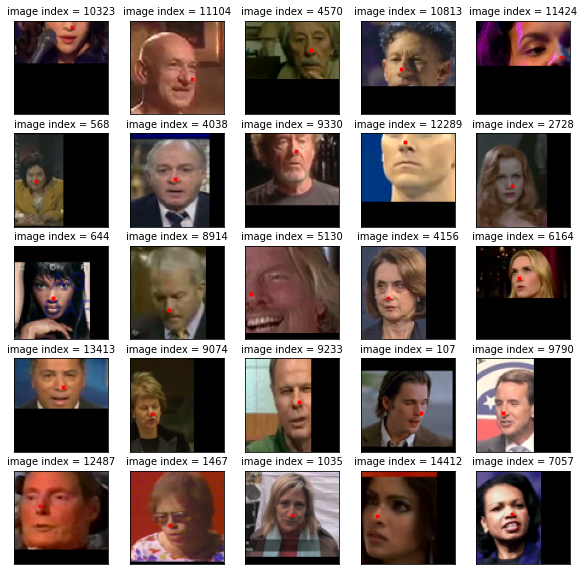

In [5]:
plot_faces(X_train, Y_train)

In [6]:
print(X_train.shape)
print(Y_train.shape)

(14428, 78, 78, 3)
(14428, 2)


In [7]:
print(X_train.max(), X_train.min(), X_train.mean())
print(Y_train.max(), Y_train.min(), Y_train.mean())

255.0 0.0 74.75173797846992
75.7840909090909 1.09375 35.63654423757711


## Create cross validation set

In [8]:
# Cross Validation set size
val_size = 1700
random_seed=21
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=val_size / X_train.shape[0], random_state=random_seed)

In [9]:
print(X_train.shape, Y_train.shape)
print(X_val.shape, Y_val.shape)
print(X_test.shape, Y_test.shape)

(12728, 78, 78, 3) (12728, 2)
(1700, 78, 78, 3) (1700, 2)
(770, 78, 78, 3) (770, 2)


## Models

In [11]:
models_path = os.path.abspath(os.path.join('..'))
if models_path not in sys.path:
    sys.path.append(models_path)
from models.cascade import build_cascade_model
from models.resnet import build_resnet_model
from models.generators import build_cnn_generators, build_resnet_generators, train_with_custom_augmentation

## Model with architecture following [paper ](http://mmlab.ie.cuhk.edu.hk/archive/CNN_FacePoint.htm)

In [12]:
model = build_cascade_model(IMG_SIZE, r_rate=0.0, dr_rate=0.0)
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
max_pooling2d (MaxPooling2D) (None, 39, 39, 3)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 36, 36, 60)        2940      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 18, 18, 60)        0         
_________________________________________________________________
dropout (Dropout)            (None, 18, 18, 60)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 16, 120)       64920     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 120)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 120)         0

### Generators

In [68]:
train_gen, val_gen = build_cnn_generators(X_train, X_val)

### Compile model

In [15]:
lr=1e-4
opt = Adam(learning_rate=lr)
model.compile(loss='mean_squared_error', optimizer=opt)

### Training

In [16]:
b_size = 64
# Model expects target in [0, 1]
Y_train, Y_val, Y_test = scale_target([Y_train, Y_val, Y_test], IMG_SIZE)
history = model.fit(train_gen.flow(X_train, Y_train, batch_size=b_size),
          steps_per_epoch=len(X_train) / b_size, epochs=20, validation_data = val_gen.flow(X_val, Y_val, batch_size=b_size) )

Epoch 1/20
199/198 [==============================] - 25s 123ms/step - loss: 0.0147 - val_loss: 0.0106
Epoch 2/20
199/198 [==============================] - 29s 148ms/step - loss: 0.0105 - val_loss: 0.0090
Epoch 3/20
199/198 [==============================] - 29s 148ms/step - loss: 0.0087 - val_loss: 0.0075
Epoch 4/20
199/198 [==============================] - 30s 148ms/step - loss: 0.0073 - val_loss: 0.0062
Epoch 5/20
199/198 [==============================] - 29s 146ms/step - loss: 0.0061 - val_loss: 0.0052
Epoch 6/20
199/198 [==============================] - 30s 152ms/step - loss: 0.0054 - val_loss: 0.0046
Epoch 7/20
199/198 [==============================] - 30s 150ms/step - loss: 0.0048 - val_loss: 0.0051
Epoch 8/20
199/198 [==============================] - 29s 146ms/step - loss: 0.0044 - val_loss: 0.0038
Epoch 9/20
199/198 [==============================] - 29s 148ms/step - loss: 0.0039 - val_loss: 0.0036
Epoch 10/20
199/198 [==============================] - 32s 161ms/step - l

In [17]:
# Unused training method
# Works significantly slower

# function expects target in [0, IMG_SIZE]
# Y_train, Y_val, Y_test = rescale_target([Y_train, Y_val, Y_test], IMG_SIZE)
# train_with_custom_augmentation(model, X_train, Y_train, batch_size=64, aug_prob=(0.2, 0.2), epochs=20)

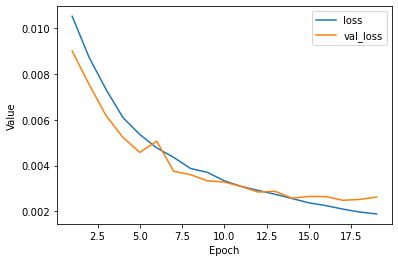

In [18]:
epochs = history.epoch
hist = pd.DataFrame(history.history)
metrics = ['loss', 'val_loss']
plot_curve(epochs, hist, metrics)

In [70]:
# Additional training with smaller learning rate
lr=1e-5
opt = Adam(learning_rate=lr)
model.compile(loss='mean_squared_error', optimizer=opt)
b_size = 64
history = model.fit(train_gen.flow(X_train, Y_train, batch_size=b_size),
          steps_per_epoch=len(X_train) / b_size, epochs=10, validation_data = val_gen.flow(X_val, Y_val, batch_size=b_size) )

Epoch 1/10
199/198 [==============================] - 28s 140ms/step - loss: 7.9922e-04 - val_loss: 0.0019
Epoch 2/10
199/198 [==============================] - 32s 159ms/step - loss: 7.7001e-04 - val_loss: 0.0019
Epoch 3/10
199/198 [==============================] - 33s 168ms/step - loss: 7.6115e-04 - val_loss: 0.0019
Epoch 4/10
199/198 [==============================] - 34s 172ms/step - loss: 7.5294e-04 - val_loss: 0.0019
Epoch 5/10
199/198 [==============================] - 35s 176ms/step - loss: 7.4240e-04 - val_loss: 0.00192s 
Epoch 6/10
199/198 [==============================] - 36s 182ms/step - loss: 7.3500e-04 - val_loss: 0.0019
Epoch 7/10
199/198 [==============================] - 35s 176ms/step - loss: 7.2714e-04 - val_loss: 0.0019
Epoch 8/10
199/198 [==============================] - 34s 169ms/step - loss: 7.1289e-04 - val_loss: 0.0019
Epoch 9/10
199/198 [==============================] - 33s 164ms/step - loss: 7.1052e-04 - val_loss: 0.0019
Epoch 10/10
199/198 [=============

## Evaluate model

In [67]:
max_rgb = 255.0
model.evaluate(X_test / max_rgb, Y_test)

25/25 [==============================] - 0s 15ms/step - loss: 0.0380: 0s - loss: 0.038


0.03795222193002701

## Test model

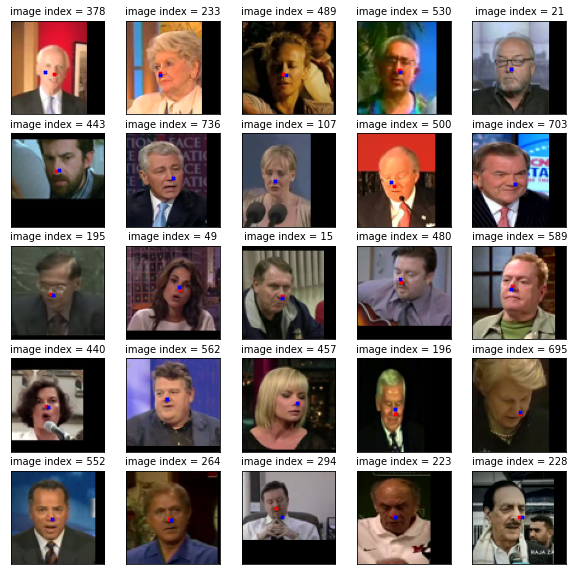

In [71]:
Y_test_pred = model.predict(X_test / max_rgb)
plot_predictions(X_test, Y_test * IMG_SIZE , Y_test_pred * IMG_SIZE)

In [25]:
pictures_path = os.path.join("..", "pictures")

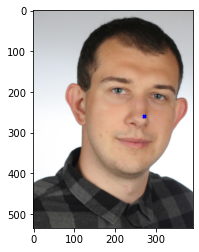

In [72]:
test_model(os.path.join(pictures_path, "test1.png"), model, IMG_SIZE)

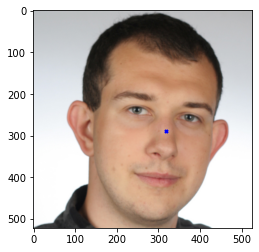

In [73]:
test_model(os.path.join(pictures_path, "test2.png"), model, IMG_SIZE)

## Transfer learning model
### Load model

In [31]:
tl_model = build_resnet_model((IMG_SIZE, IMG_SIZE, 3))

In [32]:
tl_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resnet50 (Model)             (None, 3, 3, 2048)        23587712  
_________________________________________________________________
sequential_1 (Sequential)    (None, 2)                 4453082   
Total params: 28,040,794
Trainable params: 5,507,802
Non-trainable params: 22,532,992
_________________________________________________________________


### Generators

In [33]:
train_gen, val_gen = build_resnet_generators(X_train, X_val)

### Compile model

In [34]:
lr=1e-4
opt = Adam(learning_rate=lr)
tl_model.compile(loss='mean_squared_error', optimizer=opt)

### Training

In [36]:
b_size = 64
# Model expects target in [0, 1]
Y_train, Y_val, Y_test = scale_target([Y_train, Y_val, Y_test], IMG_SIZE)
history = tl_model.fit(train_gen.flow(X_train, Y_train, batch_size=b_size),
          steps_per_epoch=len(X_train) / b_size, epochs=20, validation_data=val_gen.flow(X_val, Y_val, batch_size=b_size))

Epoch 1/20
199/198 [==============================] - 116s 582ms/step - loss: 4.6843e-04 - val_loss: 0.0039
Epoch 2/20
199/198 [==============================] - 121s 607ms/step - loss: 4.5185e-04 - val_loss: 0.0037
Epoch 3/20
199/198 [==============================] - 126s 633ms/step - loss: 4.5960e-04 - val_loss: 0.0037
Epoch 4/20
199/198 [==============================] - 141s 711ms/step - loss: 4.3408e-04 - val_loss: 0.0036
Epoch 5/20
199/198 [==============================] - 158s 795ms/step - loss: 3.9870e-04 - val_loss: 0.0036
Epoch 6/20
199/198 [==============================] - 155s 778ms/step - loss: 4.0716e-04 - val_loss: 0.0036
Epoch 7/20
199/198 [==============================] - 151s 757ms/step - loss: 3.8847e-04 - val_loss: 0.0036
Epoch 8/20
199/198 [==============================] - 154s 774ms/step - loss: 3.7901e-04 - val_loss: 0.0035
Epoch 9/20
199/198 [==============================] - 156s 786ms/step - loss: 3.6657e-04 - val_loss: 0.0034
Epoch 10/20
199/198 [=======

[[0.44019613 0.44178662]]


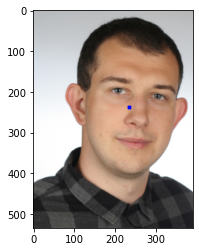

In [52]:
test_tl_model(os.path.join(pictures_path, "test1.png"), tl_model, IMG_SIZE)

[[0.5211273 0.5421392]]


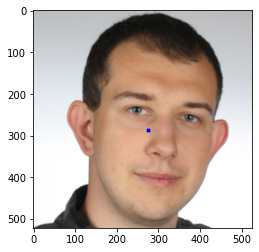

In [61]:
test_tl_model(os.path.join(pictures_path, "test2.png"), tl_model, IMG_SIZE)

## Save model

In [75]:
# Save cascade model
#model.save(os.path.join("..", 'saved_models', 'cascade_model'))
# Save resnet model
# tl_model.save(os.path.join("..", 'saved_models', 'resnet_model'))